$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [199]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [200]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

In [201]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

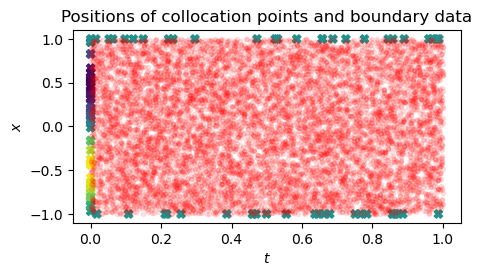

In [202]:
fig = plt.figure(figsize=(5,2.5))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [203]:
# Define the neural network with scaling
class PINN(tf.keras.Model):
    def __init__(self, layers, activation_function, lb, ub):
        super(PINN, self).__init__()
        self.layers_ = []
        self.scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)  # Scaling layer
        for layer_width in layers[:-1]:
            self.layers_.append(tf.keras.layers.Dense(layer_width, activation='tanh'))
        self.layers_.append(tf.keras.layers.Dense(layers[-1], activation=None))  # Output layer

    def call(self, x):
        x = self.scaling_layer(x)
        for layer in self.layers_:
            x = layer(x)
        return x

In [204]:
def get_r(model, X_r):
    with tf.GradientTape(persistent=True) as tape:
        t, x = X_r[:, 0:1], X_r[:, 1:2]
        tape.watch(t)
        tape.watch(x)
        u = model(tf.stack([t[:, 0], x[:, 0]], axis=1))
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    del tape
    return fun_r(t, x, u, u_t, u_x, u_xx)

In [205]:
def compute_loss(model, X_r, X_data, u_data):
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    loss = phi_r
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    return loss

In [206]:
def get_grad(model, X_r, X_data, u_data):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, X_r, X_data, u_data)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g

In [207]:
def train_step(model, X_r, X_data, u_data, optimizer):
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

In [208]:
# Initialize the model
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]  # Neural network architecture
activation_function = tf.keras.activations.tanh  # Base activation function
model = PINN(layers, activation_function, lb, ub)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [209]:
# Training loop
epochs = 5000
for epoch in range(epochs):
    loss = train_step(model, X_r, X_data, u_data, optim)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 0.6559968590736389
Epoch 100, Loss: 0.15540839731693268
Epoch 200, Loss: 0.09395748376846313
Epoch 300, Loss: 0.1441788673400879
Epoch 400, Loss: 0.05061493068933487
Epoch 500, Loss: 0.11074057221412659
Epoch 600, Loss: 0.08031246811151505
Epoch 700, Loss: 0.21816061437129974
Epoch 800, Loss: 0.08113553375005722
Epoch 900, Loss: 0.208936408162117
Epoch 1000, Loss: 0.18721801042556763
Epoch 1100, Loss: 0.1580560952425003
Epoch 1200, Loss: 0.10931491106748581
Epoch 1300, Loss: 0.10232432931661606
Epoch 1400, Loss: 0.09597847610712051
Epoch 1500, Loss: 0.08931468427181244
Epoch 1600, Loss: 0.08423390239477158
Epoch 1700, Loss: 0.08075930178165436
Epoch 1800, Loss: 0.0778486356139183
Epoch 1900, Loss: 0.07474180310964584
Epoch 2000, Loss: 0.07175754010677338
Epoch 2100, Loss: 0.0684819146990776
Epoch 2200, Loss: 0.06465958058834076
Epoch 2300, Loss: 0.059181321412324905
Epoch 2400, Loss: 0.05157517269253731
Epoch 2500, Loss: 0.04251432046294212
Epoch 2600, Loss: 0.0344446450

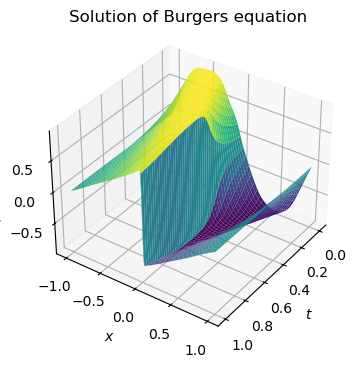

In [210]:

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

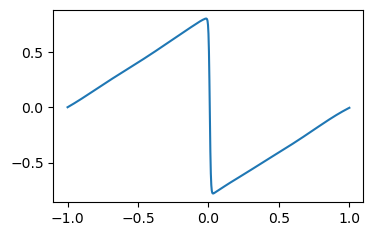

In [228]:
fig = plt.figure(figsize=(4,2.5))
tspace= 0.9
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
plt.plot(X,upred)